In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# implementation of https://arxiv.org/pdf/1508.06576.pdf

In [3]:
def load_image(image_path, transform=None, max_size=None, shape=None):
    image = Image.open(image_path)
    if max_size:
        scale = max_size / max(image.size)
        size= np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
         
    if shape:
        image = image.resize(shape, Image.LANCZOS)
        
    if transform:
        image = transform(image).unsqueeze(0)
        
    return image.to(device)

In [4]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
content = load_image("./jpg/content.jpg", transform, shape=[400, 300])
style = load_image("./jpg/style.jpg", transform, shape=[400, 300])

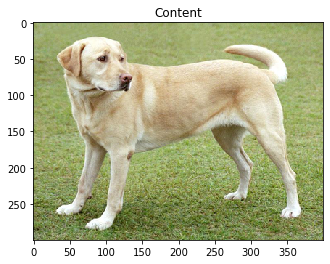

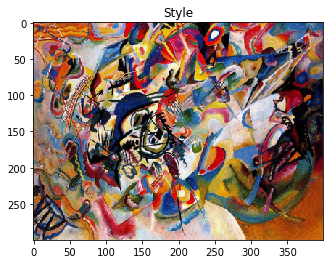

In [7]:
plt.figure()
imshow(content[0], title='Content')
imshow(style[0], title="Style")

In [8]:
content.shape

torch.Size([1, 3, 300, 400])

In [9]:
style.shape

torch.Size([1, 3, 300, 400])

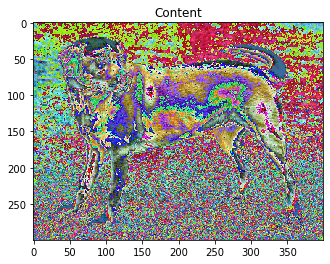

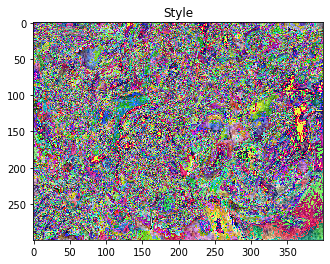

In [10]:
# normalzie photos using ImageNet's mean and variance
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

content = load_image("./jpg/content.jpg", transform, shape=[400, 300])
style = load_image("./jpg/style.jpg", transform, shape=[400, 300])

plt.figure()
imshow(content[0], title='Content')
imshow(style[0], title="Style")

In [11]:
model = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/lantao/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [12]:
dict(model._modules)

{'0': Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '1': ReLU(inplace=True),
 '2': Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '3': ReLU(inplace=True),
 '4': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 '5': Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '6': ReLU(inplace=True),
 '7': Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '8': ReLU(inplace=True),
 '9': MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 '10': Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '11': ReLU(inplace=True),
 '12': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '13': ReLU(inplace=True),
 '14': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '15': ReLU(inplace=True),
 '16': Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 '17': ReLU(inplace=True),
 '18': MaxPool2d(kernel_si

In [13]:
# use VGG to extract image features
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        self.select = ["0", "5", "10", "19", "28"]
        self.vgg = models.vgg19(pretrained=True).features
    
    def forward(self, x):
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features

In [14]:
vgg = VGGNet().to(device).eval() # eval model, requires_grad = False for all parameters. Because we don't need to train vgg, it is used for feature extraction

In [15]:
features = vgg(content)

In [16]:
for f in features:
    print(f.shape)

torch.Size([1, 64, 300, 400])
torch.Size([1, 128, 150, 200])
torch.Size([1, 256, 75, 100])
torch.Size([1, 512, 37, 50])
torch.Size([1, 512, 18, 25])


In [17]:
target = content.clone().requires_grad_(True) # target is being trained

In [18]:
optimizer = torch.optim.Adam([target], lr = 0.003, betas=[0.5, 0.999])

In [19]:
epochs = 2000

for epoch in range(epochs):
    target_features = vgg(target)
    content_features = vgg(content)
    style_features = vgg(style)
    
    content_loss = style_loss = 0
    
    for f1, f2, f3 in zip(target_features, content_features, style_features):
        
        content_loss += torch.mean((f1 - f2)**2)
        # use Gram matrix to compute style loss as described in https://arxiv.org/pdf/1508.06576.pdf
        _, c, h, w = f1.shape
        f1 = f1.view(c, h*w) # (c, h*w)
        f3 = f3.view(c, h*w) # (c, h*w)
        
        f1 = torch.mm(f1, f1.t()) # (c, c)
        f3 = torch.mm(f3, f3.t()) # (c, c)
        style_loss += torch.mean((f1 - f3) ** 2) / (c*h*w)
    
    loss = content_loss + style_loss * 100. # 100 is the weight between content loss and style loss
    
    # upate target tensor
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print("Epoch [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}"
              .format(epoch, epochs, content_loss.item(), style_loss.item()))  

Epoch [0/2000], Content Loss: 0.0000, Style Loss: 3429.7876
Epoch [100/2000], Content Loss: 36.6180, Style Loss: 851.2203
Epoch [200/2000], Content Loss: 48.1899, Style Loss: 399.2355
Epoch [300/2000], Content Loss: 53.6521, Style Loss: 247.4478
Epoch [400/2000], Content Loss: 56.8232, Style Loss: 168.8793
Epoch [500/2000], Content Loss: 59.0368, Style Loss: 121.7904
Epoch [600/2000], Content Loss: 60.6743, Style Loss: 91.8243
Epoch [700/2000], Content Loss: 61.9665, Style Loss: 71.9638
Epoch [800/2000], Content Loss: 63.0124, Style Loss: 58.3787
Epoch [900/2000], Content Loss: 63.8489, Style Loss: 48.8285
Epoch [1000/2000], Content Loss: 64.5539, Style Loss: 41.9134
Epoch [1100/2000], Content Loss: 65.1603, Style Loss: 36.7630
Epoch [1200/2000], Content Loss: 65.6856, Style Loss: 32.8153
Epoch [1300/2000], Content Loss: 66.1604, Style Loss: 29.6974
Epoch [1400/2000], Content Loss: 66.5750, Style Loss: 27.1723
Epoch [1500/2000], Content Loss: 66.9372, Style Loss: 25.0808
Epoch [1600/20

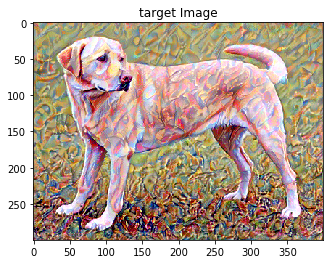

In [20]:
denorm = transforms.Normalize([-2.12, -2.04, -1.80], [4.37, 4.46, 4.44]) # denormalize using ImageNet's mean and variance
img = target.clone().squeeze()
img = denorm(img).clamp_(0,1)
imshow(img, title="target Image")